# Laboratory work 4
## Variant 27
<b>NN architecture:</b> WideResNet28-10 <br/>
<b>Optimizer:</b> Adam <br/>
<b>Semi-supervised algorithm:</b> MixMatch <br/>
<b>Dataset:</b> Cifar10 <br/>
<b>link to dataset:</b> https://www.cs.toronto.edu/~kriz/cifar.html

# The CIFAR-10 dataset
The <b>CIFAR-10</b> dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Imports

In [2]:
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchmetrics
import random
import math
import os
import gc
import PIL
import copy

from tqdm.notebook import tqdm
from torch.autograd import Variable
from sklearn.model_selection import StratifiedKFold, train_test_split

In [7]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Reproducibility

In [8]:
RAND_CONST = 10
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(RAND_CONST)
g_train_L = torch.Generator().manual_seed(RAND_CONST + 1)
g_train_UL = torch.Generator().manual_seed(RAND_CONST + 2)
g_test = torch.Generator().manual_seed(RAND_CONST + 3)

In [9]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(RAND_CONST)
# Set python seed
random.seed(RAND_CONST)
# Set numpy seed
np.random.seed(RAND_CONST)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)

# Data read
This dataset already has train and test split (0.833 - 50000 to 0.167 - 10000). Let's further split it into:
```
1. train labeled set (30%)     25%       15000 images
2. train unlabeled set (70%)   58.33%    35000 images
3. test set                    16.67%    10000 images
Total images used for sets: 60000
```

In [10]:
train_labeled_len = 15000
valid_unlabeled_len = 35000
test_len = 10000

## Define transformers for data

In [11]:
# Calculate mean and std of test and train sets (255 - possible pixel value range)
traindata = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True).data / 255
testdata = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True).data / 255
MEAN_TRN = traindata.mean(axis = (0,1,2)) 
STD_TRN = traindata.std(axis = (0,1,2))
MEAN_TST = testdata.mean(axis = (0,1,2)) 
STD_TST = testdata.std(axis = (0,1,2))


# Create sequence of transformations: data -> (random horizontal flip for training data)
#        -> (random crop with reflection for missing pixels for training data)
#        -> tensor -> (tensor - mean) / std

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=32,
                      padding=int(32*0.125),
                      padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(MEAN_TRN, STD_TRN),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN_TST, STD_TST),
])

# Number of images in each batch, recommended to == 2^n
BATCH_SIZE = 64

# 10 classes used in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Clear memory
del traindata
del testdata
gc.collect()

100%|██████████| 170498071/170498071 [00:03<00:00, 46085741.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


42146

## Creating dataloaders for train, validation and test datasets
### Ordinary training:

In [12]:
# Download CIFAR10 trainset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_train)

# Create a sampler, that provides an iterable over train dataset (used in OrdinaryTraining)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0,
    worker_init_fn=seed_worker, generator=g_train)

# Download CIFAR10 testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)

# Create a sampler for testset (used in OrdinaryTraining)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=0,
    worker_init_fn=seed_worker, generator=g_test)

### MixMatch training:

In [10]:
# Class that is used for creating labelled CIFAR10 dataset
# for MixMatch-Training
class CIFAR_labeled(torch.utils.data.Dataset):
    def __init__(self, data, targets, indexes=None, transform=None):
        super(CIFAR_labeled, self).__init__()
        if indexes is None:
            self.data = data
            self.targets = targets
        else:
            # store data with idx from indexes
            self.data = data[indexes]
            self.targets = np.array(targets)[indexes]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
        img = PIL.Image.fromarray(img) # convert to PIL.Image format
        if self.transform is not None:
            img = self.transform(img) # if defined perform transformation on image

        return img, target

    def __len__(self):
        return len(self.data)

# Same dataset as CIFAR_labeled except that there
# are no labels (labels == -1)
class CIFAR_unlabeled(CIFAR_labeled):
    def __init__(self, data, targets, indexes=None, transform=None):
        super(CIFAR_unlabeled, self).__init__(data, targets, indexes, transform)
        self.targets = np.array([-1 for _ in range(len(self.targets))])

# Passed instead of transform, performs K random transformations when invoked
class RandomAugmentation:
    def __init__(self, K, transform):
        self.transform = transform
        self.K = K

    def __call__(self, x):
        # Applying stochastic augmentation K times
        return [self.transform(x) for _ in range(self.K)]
    
labels = trainset.targets

# Perform stratified random split into labeled training (30%) and unlabeled training (70%) sets
train_labeled_ind, train_unlabeled_ind = train_test_split(
    list(range(len(trainset))), test_size=0.7, random_state=RAND_CONST, stratify=labels)

## Data visualization

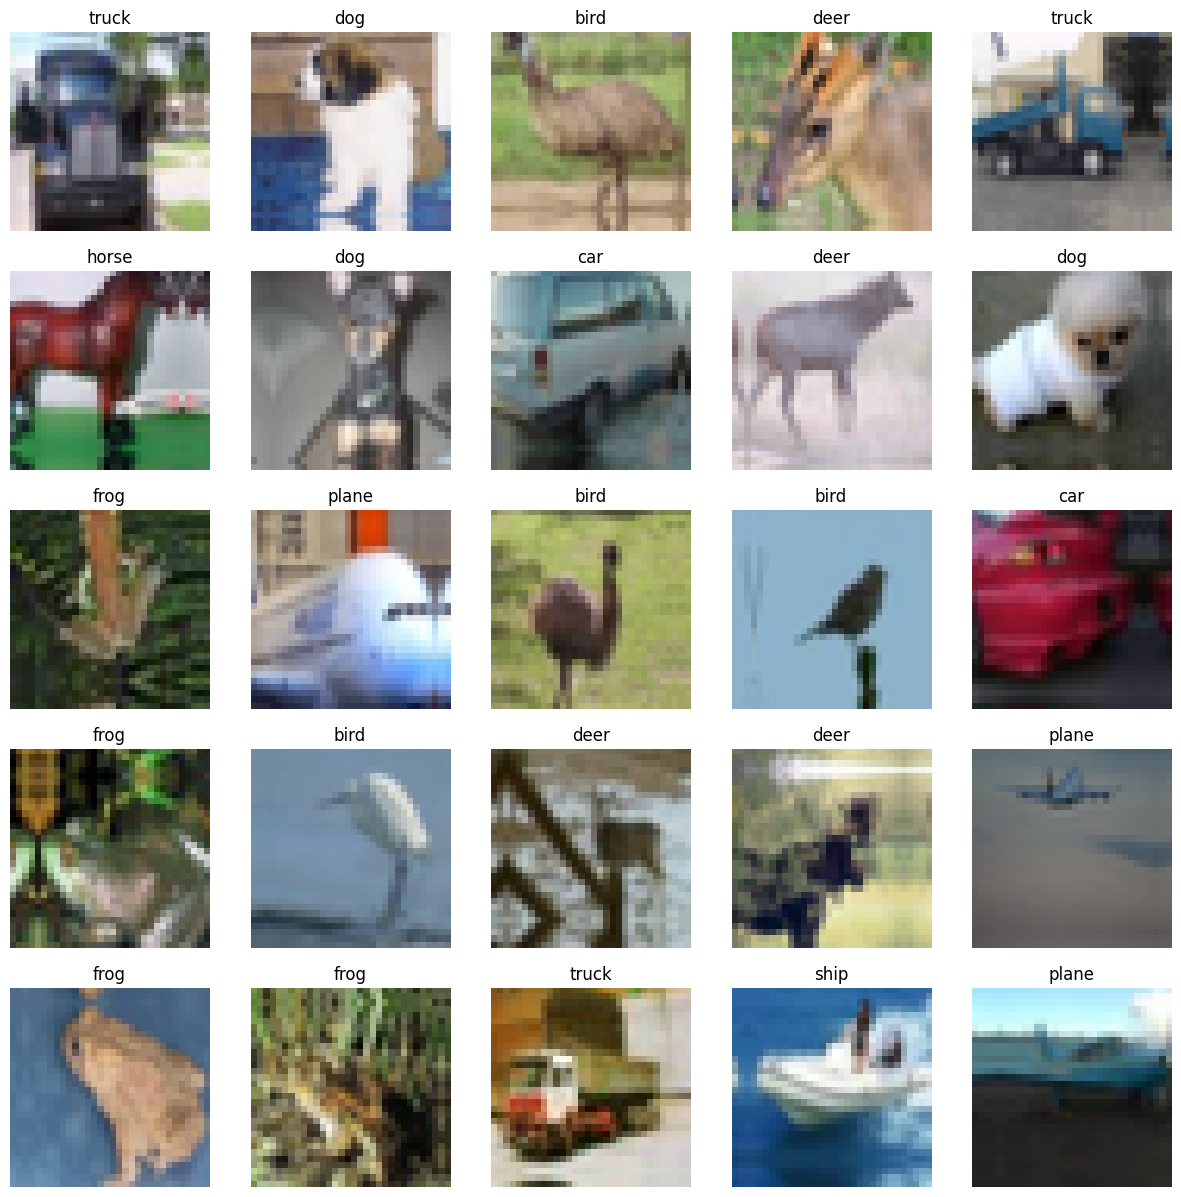

In [11]:
def imshow(img):
    # Unnormalize image
    img = img * STD_TRN[:, None, None] + MEAN_TRN[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels in a grid 5x5
fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(0, rows * cols):
    img, label = images[i], labels[i]
    fig.add_subplot(rows, cols, i + 1)
    imshow(img)
    plt.title(classes[label])
    plt.axis(False)

In [15]:
# Set up loss criterion (used in OrdinaryTraining)
criterion = nn.CrossEntropyLoss()
# Set up and send to GPU accuracy metric
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes)).to(device)
print(f"Amount of batches processed in each epoch during full ordinary training: {len(train_loader)}")

Amount of batches processed in each epoch during full ordinary training: 781


## Class, that creates abstraction for model, dataloaders, optimizer, criterion, etc., and allows to train, validate and test this model with the use of "ordinary" training

In [34]:
class OrdinaryTraining:
    def __init__(self, model, optimizer, criterion, accuracy, train_loader, test_loader, device,
                 checkpoint_dir=None):
        """
        Parameters
        ----------
        model :
            CNN architecture model, already created and sent to device
        optimizer :
            Already instantiated optimizer
        criterion :
            Already instantiated criterion
        accuracy :
            Already instantiated accuracy
        train_loader :
            Batch loader of train data
        test_loader :
            Batch loader of test data
        device :
            Device where data will be sent to (for example cuda)
        checkpoint_dir : optional
            Path to directory where checkpoint state lies
        """
        
        self.optimizer = optimizer
        self.criterion = criterion
        self.accuracy = accuracy
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.train_batches_num = len(train_loader)
        self.test_batches_num = len(test_loader)
        self.model = model
        self.arr_loaded = False # whether we loaded loss and accuracy arrays
        
        # Load training model from checkpoint
        if checkpoint_dir is not None:
            print("Loading OrdinaryTraining model from checkpoint...")
            checkpoint = torch.load(checkpoint_dir)
            self.model.load_state_dict(checkpoint['model_param'])
            self.start_epoch = checkpoint['current_epoch'] + 1
            self.best_accuracy = checkpoint['best_accuracy']
            
            # Load loss and accuracy arrays
            self.train_loss_arr = checkpoint['train_loss_arr']
            self.val_loss_arr = checkpoint['val_loss_arr']
            self.val_accuracy_arr = checkpoint['val_accuracy_arr']
            self.arr_loaded = True
            
            # Load environment state
            torch.set_rng_state(checkpoint['rng_state'])
            torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])
            np.random.set_state(checkpoint['np_random_state'])
            random.setstate(checkpoint['random_state'])
            print(f"!This checkpoint trained for {self.start_epoch} epochs, "
                  f"current start_epoch={self.start_epoch + 1}!")
        # Create blank training model
        else:
            print("Creating OrdinaryTraining model from scratch...")
            self.start_epoch = 0
            self.best_accuracy = 0
        print("Model successfully created!")
        self.checkpoint_directory = f'{type(self.model).__name__}_Ordinary_checkpoints'
        
    def train_validate_cycle(self, epochs, cycle_epoch=1, cycle_batch=300):
        """
        Parameters
        ----------
        epochs :
            Number of training and validation cycle epochs
        cycle_epoch : optional
            The number that determines after which amount of epochs information will be displayed
        cycle_batch :  optional
            The number that determines after which amount of batches in each epoch information will
            be displayed
        """
        # Define flag for info display
        print_ind = False

        # Create required arrays to store loss and accuracy
        if not self.arr_loaded:
            self.train_loss_arr = []
            self.val_loss_arr = []
            self.val_accuracy_arr = []
        self.epochs = epochs
        
        ##### Training for epochs #####
        # Create training and validation loop
        print(f"Training model for {epochs} epochs from {self.start_epoch + 1} to"
              f" {self.start_epoch + epochs}.")
        for epoch in tqdm(range(self.start_epoch, self.start_epoch + epochs)):
            if (epoch + 1) % cycle_epoch == 0:
                print(f"Current epoch: {epoch + 1}\n-------")
                print_ind = True

            ##### Training #####
            train_loss = val_acc = val_loss = 0
            
            # Set network to train mode
            self.model.train()

            # Add a loop through training batches
            for batch_num, (tr_inputs, tr_labels) in tqdm(enumerate(self.train_loader),
                                                          total=len(self.train_loader)):
                # Send data to cuda (preferably)
                tr_inputs = tr_inputs.to(self.device)
                tr_labels = tr_labels.to(self.device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward, backward pass + optimization
                outputs = self.model(tr_inputs).to(self.device)
                loss = self.criterion(outputs, tr_labels)
                loss.backward()
                self.optimizer.step()

                # Accumulatively add up the loss per epoch 
                train_loss += loss

                # Print out how many samples have been seen
                # Output loss each cycle batches (cycle*batch samples)
                if (batch_num + 1) % cycle_batch == 0 and batch_num != 0 and print_ind:
                    print(f"Looked at {batch_num * BATCH_SIZE} samples")
                    print(f"Current train loss for batch: {loss}")

                # Clearing memory
                del tr_inputs
                del tr_labels
                del outputs
            ##### Training end #####

            ##### Validation #####
            # Set network to evaluation mode
            self.model.eval()
            # Turn on inference mode (no autograd)
            with torch.inference_mode():
                for val_inputs, val_labels in self.test_loader:
                    # Send data to cuda (preferably)
                    val_inputs = val_inputs.to(self.device)
                    val_labels = val_labels.to(self.device)
                    predictions = self.model(val_inputs).to(self.device)

                    # Test loss and accuracy calculation
                    val_loss += self.criterion(predictions, val_labels)
                    val_acc += self.accuracy(predictions.argmax(dim=1), val_labels)

                    # Clearing memory
                    del val_inputs
                    del val_labels
                    del predictions
            ##### Validation end #####

                # Save average (throughout the epoch) loss and accuracy
                self.train_loss_arr.append(train_loss.item() / self.train_batches_num)
                self.val_loss_arr.append(val_loss.item() / self.test_batches_num)
                self.val_accuracy_arr.append(val_acc.item() / self.test_batches_num)
                
                # Check if length of arrays is appropriate
                assert len(self.train_loss_arr)==len(self.val_loss_arr)\
                    ==len(self.val_accuracy_arr)
                assert epoch + 1 == len(self.train_loss_arr)
                
                if (epoch + 1) % cycle_epoch == 0:
                    # Print out average loss and accuracy of this epoch each cycle_epoch
                    print(f"\nAverage train loss: {self.train_loss_arr[epoch]:.5f}")
                    print(f"Average validation loss: {self.val_loss_arr[epoch]:.5f}, "
                          f"Average validation acc: {100*self.val_accuracy_arr[epoch]:.2f}%\n")
                    print_ind = False
                    
                # Save checkpoint in case of better accuracy on validation set
                if self.best_accuracy < self.val_accuracy_arr[epoch]:
                    print(f'\nSaving {epoch+1} status:\'best\' checkpoint, '
                          f'current average accuracy: {100*self.val_accuracy_arr[epoch]:.2f}% is '
                          f'better than previous best result: {100*self.best_accuracy:.2f}%')
                    self.best_accuracy = self.val_accuracy_arr[epoch]
                    self.checkpoint(epoch, 'best')
                else:
                    print(f'\nSaving {epoch+1} status:\'last\' checkpoint, '
                          f'current average accuracy: {self.val_accuracy_arr[epoch]:.2f}%')
                    self.checkpoint(epoch, 'last')
                    
            # Garbage collection     
            gc.collect()
            torch.cuda.empty_cache()
        ##### Training for epochs END #####
        self.start_epoch += epochs # Save current epoch to start new training from it
    
    def checkpoint(self, current_epoch, status):
        """ Save current_epoch checkpoint """
                # Saving loss and accuracy arrays
        state = {
            'model_param': self.model.state_dict(),
            'current_epoch': current_epoch,
            'best_accuracy': self.best_accuracy,
            'train_loss_arr': self.train_loss_arr,
            'val_loss_arr': self.val_loss_arr,
            'val_accuracy_arr': self.val_accuracy_arr,
            'rng_state': torch.get_rng_state(),
            'cuda_rng_state':torch.cuda.get_rng_state(),
            'np_random_state': np.random.get_state(), 
            'random_state': random.getstate()
        }
        
        if not os.path.isdir(self.checkpoint_directory):
            os.mkdir(self.checkpoint_directory)
            
        torch.save(state, './'+ self.checkpoint_directory +\
                   f'/epoch_{current_epoch + 1}_{status}_cpt')
        print(f'Successfully saved epoch {current_epoch + 1} status:{status} checkpoint!\n')
    
    def model_test(self): # Doesn't perform test in usual sense, because it uses the same validation set,
                          # that was used during training
        test_loss = test_acc = 0
        
        ##### Test #####
        # Set network to evaluation mode
        self.model.eval()
        # Turn on inference mode (no autograd)
        with torch.inference_mode():
            for test_inputs, test_labels in self.test_loader:
                # Send data to cuda (preferably)
                test_inputs = test_inputs.to(self.device)
                test_labels = test_labels.to(self.device)
                predictions = self.model(test_inputs).to(self.device)

                # Test loss and accuracy calculation
                test_loss += self.criterion(predictions, test_labels)
                test_acc += self.accuracy(predictions.argmax(dim=1), test_labels)

                # Clearing memory
                del test_inputs
                del test_labels
                del predictions
        ##### Test end #####

            # Save average (throughout the epoch) loss and accuracy
            test_loss_score = test_loss / self.test_batches_num
            test_accuracy_score = test_acc / self.test_batches_num

            gc.collect()
            torch.cuda.empty_cache()

        return test_loss_score, test_accuracy_score
    
    def plot_loss_acc(self):
        """
        Plot loss plots for train and validations sets and accuracy plot for validation set.
        Works with latest epochs, train and val loss and val accuracy value and arrays respectively.
        """
        plt.figure(figsize = (15, 5))
        epoch_arr = np.arange(1, len(self.train_loss_arr) + 1)
        plt.subplot(121)
        plt.plot(epoch_arr, self.train_loss_arr, 'r', label='Average train loss')
        plt.plot(epoch_arr, self.val_loss_arr,'b', label='Average validation loss')
        plt.title("Average loss")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        plt.subplot(122)
        plt.plot(epoch_arr, self.val_accuracy_arr, 'b')
        plt.title("Average validation accuracy")
        plt.xlabel("Epoch number")
        plt.ylabel("Accuracy value")
        plt.show()

# Class that performs MixMatch-Training

In [16]:
# Define hyperparameters
LAMBDA_U = 75
T = 0.5
K = 2
ALPHA = 0.75
NUM_CLASSES = 10

# Class that leads the Exponential Moving Average (EMA) model
class EMAModel(nn.Module):
    def __init__(self, model, decay_func="const", decay=0.999):
        super(EMAModel, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.ema_model = copy.deepcopy(model).to("cuda")
        self.ema_model.eval()
        self.decay = decay
        self.decay_func = decay_func # "const" or "exp"

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_param, model_param in zip(self.ema_model.state_dict().values(), model.state_dict().values()):
                model_param = model_param.to("cuda")
                ema_param.copy_(update_fn(ema_param, model_param))

    def step(self, model, iter_ratio=None):
        # iter_ratio should be a value from 0 to 1, equals to
        # current_training_step/total_training_steps
        if self.decay_func == "exp":
            assert iter_ratio is not None
            current_decay = self.decay * (1 - np.exp(-iter_ratio * 15))
        else:
            current_decay = self.decay # "const" decay case
        # e - ema_model, m (model) - ordinary model
        self._update(model, update_fn=lambda e, m: current_decay * e + (1. - current_decay) * m)


# Class that perdorms sharpening, MixUp and calculates loss L_X, L_U
class MixMatchLoss(nn.Module):
    def __init__(self, epochs, device):
        super().__init__()
        self.epochs = epochs
        self.beta_dist = torch.distributions.beta.Beta(ALPHA, ALPHA)
        self.device = device

    def sharpen(self, y):
        y = y.pow(1/T)
        return y / y.sum(dim=1, keepdim=True)

    def cal_loss(self, logits_x, y, logit_u_x, y_hat, current_epoch_ramp):
        """
        :param logits_x            : f(x)
        :param y                   : true target of x
        :param logit_u_x           : f(u_x)
        :param y_hat               : guessed label of u_x
        :param current_epoch_ramp  : current epoch ramp
        :return                    : CE loss of x, mse loss of (f(u_x), y_hat), weight of u_x
        """
        L_X = -torch.mean(torch.sum(torch.log(logits_x) * y, dim=1)) # Cross entropy (L_X loss)
        L_U = F.mse_loss(logit_u_x, y_hat) # MSE loss (L_U loss)
        # linearly ramp up the contribution of unlabeled set
        linear_weight = float(np.clip(current_epoch_ramp / self.epochs, 0.0, 1.0))

        return L_X, L_U, LAMBDA_U * linear_weight  


    def mixup(self, all_inputs, all_targets):
        lambd = self.beta_dist.sample().item()
        lambd = max(lambd, 1-lambd)
        idx = torch.randperm(all_inputs.size(0)) # shuffle the input

        # Perform MixUp
        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]
        mixed_input = lambd * input_a + (1 - lambd) * input_b
        mixed_target = lambd * target_a + (1 - lambd) * target_b
        mixed_input = list(torch.split(mixed_input, BATCH_SIZE)) # split to batches

        return mixed_input, mixed_target


    def forward(self, input):
        # Extract data
        x = input['x']
        y = input['y']
        u_x = input['u_x'] # K augmentations
        current_ramp = input['current']
        model = input['model']

        # Make onehot label
        y = F.one_hot(y, NUM_CLASSES)
        
        with torch.no_grad():
            y_hat = sum([model(u_x_k) for u_x_k in u_x]) / K # Average distribution
            y_hat = self.sharpen(y_hat)                      # Sharpened distribution
            y_hat.detach_()                                  # Cancel gradient requiring

        # Perform MixUp
        all_inputs = torch.cat([x] + u_x, dim=0)
        all_targets = torch.cat([y] + [y_hat]*K, dim=0)
        mixed_input, mixed_target = self.mixup(all_inputs, all_targets)

        logit = [model(mixed_input[i]) for i in range(len(mixed_input))]
        logits_x = logit[0]
        logits_u = torch.cat(logit[1:], dim=0)
        loss_x, loss_u, w = self.cal_loss(logits_x=logits_x, y=mixed_target[:BATCH_SIZE],
                                          logit_u_x=logits_u, y_hat=mixed_target[BATCH_SIZE:],
                                          current_epoch_ramp=current_ramp)

        del logit, logits_x, logits_u # clean memory
        return loss_x, loss_u, w 


class MixMatchTraining:  
    def __init__(self, model_creator, accuracy, train_labeled_ind, train_unlabeled_ind, trainset,
                 validset, device, checkpoint_dir=None, decay_func="const"):
        """
        Parameters
        ----------
        model_creator :
            CNN architecture of neural network (not yet instantiated, should be passed as
            lambda: CNN(...))
        train_labeled_ind :
            Indexes for labelled train set S
        train_unlabeled_ind :
            Indexes for unlabelled train set U
        trainset :
            Training set
        validset :
            Validation set
        device :
            Device where data will be sent to (for example cuda)
        checkpoint_dir : optional
            Path to checkpoint where state is saved
        decay_func : optional
            "const" - decay in ema model will be constant or
            "exp" - decay will grow exponentially with each iteration
        """
        self.device = device
        self.model = model_creator().to(self.device)
        self.decay_func = decay_func

        # Define transforms for train and test data
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomCrop(size=32,
                                  padding=int(32*0.125),
                                  padding_mode='reflect'),
            transforms.ToTensor(),
            transforms.Normalize(MEAN_TRN, STD_TRN)
            ])
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(MEAN_TST, STD_TST)
        ])

        # Create labelled and unlabelled training datasets and validation dataset
        train_labeled_dataset = CIFAR_labeled(trainset.data ,trainset.targets, train_labeled_ind,  transform=train_transform)
        train_unlabeled_dataset = CIFAR_unlabeled(trainset.data , trainset.targets, train_unlabeled_ind, transform=RandomAugmentation(K, train_transform))
        val_dataset = CIFAR_labeled(validset.data, validset.targets, transform=test_transform)


        # Define dataloaders for labelled and unlabelled trainsets and validation dataset
        self.lab_train_loader = torch.utils.data.DataLoader(train_labeled_dataset,
                                                            batch_size=BATCH_SIZE, shuffle=True,
                                                            num_workers=0, drop_last=True,
                                                            worker_init_fn=seed_worker,
                                                            generator=g_train_L)
        self.unlab_train_loader = torch.utils.data.DataLoader(train_unlabeled_dataset,
                                                              batch_size=BATCH_SIZE, shuffle=True,
                                                              num_workers=0, drop_last=True,
                                                              worker_init_fn=seed_worker,
                                                              generator=g_train_UL)
        self.val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                                      num_workers=0, drop_last=False,
                                                      worker_init_fn=seed_worker, generator=g_test)
        
        # Define loss used during evaluation
        self.eval_criterion = nn.CrossEntropyLoss().to(self.device)
        self.accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=NUM_CLASSES).to(self.device)
        # Define optimizer used for regular model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.002)
        self.arr_loaded = False # whether we loaded loss and accuracy arrays
        
        if checkpoint_dir is not None:
            print("Loading model from checkpoint...")
            checkpoint = torch.load(checkpoint_dir)
            te = checkpoint['total_epochs']
            self.model.load_state_dict(checkpoint['model_param'])
            self.optimizer.load_state_dict(checkpoint['optim_state'])
            self.ema_optimizer = checkpoint['ema_optim']
            self.start_epoch = checkpoint['current_epoch'] + 1
            self.best_accuracy = checkpoint['best_accuracy']
            self.best_ordinary_model_epoch = checkpoint['best_ordinary_model_epoch']
            self.best_ordinary_model_accuracy = checkpoint['best_ordinary_model_accuracy']
            
            # Load loss and accuracy arrays
            fill_array = np.zeros(int(te - self.start_epoch))
            self.train_loss_arr = np.concatenate((checkpoint['train_loss_arr'][:self.start_epoch],
                                                  fill_array))
            self.train_loss_x_arr = np.concatenate((checkpoint['train_loss_x_arr'][:self.start_epoch],
                                                  fill_array))
            self.train_loss_u_arr = np.concatenate((checkpoint['train_loss_u_arr'][:self.start_epoch],
                                                  fill_array))
            self.valid_loss_arr = np.concatenate((checkpoint['valid_loss_arr'][:self.start_epoch],
                                                  fill_array))
            self.valid_loss_ema_arr = np.concatenate((checkpoint['valid_loss_ema_arr'][:self.start_epoch],
                                                      fill_array))
            self.valid_accuracy_arr = np.concatenate((checkpoint['valid_accuracy_arr'][:self.start_epoch],
                                                      fill_array))
            self.valid_accuracy_ema_arr = np.concatenate((checkpoint['valid_accuracy_ema_arr'][:self.start_epoch],
                                                          fill_array))
            self.arr_loaded = True

            # Set environment state
            torch.set_rng_state(checkpoint['rng_state'])
            torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])
            np.random.set_state(checkpoint['np_random_state'])
            random.setstate(checkpoint['random_state'])
            print(f"!This checkpoint was supposed to train for {te} "
                  f"epochs, current start_epoch={self.start_epoch + 1}!")
        else:
            print("Creating model from scratch...")
            self.best_ordinary_model_epoch = 0
            self.best_ordinary_model_accuracy = 0
            self.start_epoch = 0
            self.best_accuracy = 0
            self.ema_optimizer = EMAModel(self.model, self.decay_func)
        
        self.checkpoint_directory = f'{type(self.model).__name__}_MMT_checkpoints'
        self.train_batches_num = len(self.lab_train_loader)
        self.val_batches_num = len(self.val_loader)
        
        print("Model successfully created!")
        
    def train_validate_cycle(self, epochs, cycle_epoch=1, cycle_batch=100):
        """
        Parameters
        ----------
        epochs :
            Number of training and validation cycle epochs
        cycle_batch : optional
            The number that determines after which amount of batches in each epoch information will be
            displayed
        cycle_epoch : optional
            The number that determines after which amount of epochs information will be displayed
        """
        self.epochs = epochs
        # Define loss used during training
        self.criterion = MixMatchLoss(self.epochs, self.device)
        
        # Define flag for info display
        print_ind = False

        # Create required arrays to store loss and accuracy
        if not self.arr_loaded:
            self.train_loss_arr = np.zeros(epochs)
            self.train_loss_x_arr = np.zeros(epochs)
            self.train_loss_u_arr = np.zeros(epochs)
            self.valid_loss_arr = np.zeros(epochs)
            self.valid_loss_ema_arr = np.zeros(epochs)
            self.valid_accuracy_arr = np.zeros(epochs)
            self.valid_accuracy_ema_arr = np.zeros(epochs)

        ##### Training for epochs #####
        # Create training and validation loop
        print(f"Training model for {epochs} epochs from {self.start_epoch + 1} to"
              f" {epochs}.")
        for epoch in tqdm(range(self.start_epoch, epochs)):
            if (epoch + 1) % cycle_epoch == 0:
                print(f"Current epoch: {epoch + 1}/{epochs}\n-------")
                print_ind = True

            ##### Training #####
            train_loss = train_loss_x = train_loss_u = val_loss =\
                val_acc = val_loss_ema = val_acc_ema= 0
            # Set networks to train mode
            self.model.train()
            
            # Create iterators
            train_loader_iter  = iter(self.lab_train_loader)
            u_train_loader_iter = iter(self.unlab_train_loader)
            # Loop through training batches
            for batch_num in tqdm(range(self.train_batches_num)):
                # Extract next data
                inputs_lab, labels = next(train_loader_iter)
                inputs_unlab, _ = next(u_train_loader_iter)
                inputs_lab, labels  = inputs_lab.to(self.device), labels.to(self.device)
                inputs_unlab = [u_x_k.to(self.device) for u_x_k in inputs_unlab] # K augmentations

                input_dict = {'model' : self.model, 
                    'u_x'        : inputs_unlab, 
                    'x'          : inputs_lab, 
                    'y'          : labels,
                    'current'    : epoch + batch_num/self.train_batches_num}
                
                # Calculate and propagate loss backwards
                L_X, L_U, lambda_u = self.criterion(input_dict)
                loss = L_X + L_U * lambda_u
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if self.decay_func == "const":
                    self.ema_optimizer.step(self.model)
                else:
                    self.ema_optimizer.step(self.model,
                                            (epoch + batch_num/self.train_batches_num)/self.epochs)
                
                # Custom weight decay
                with torch.no_grad():
                    for param in self.model.parameters():
                        param.mul_(1 - 0.0004)
                
                # Accumulatively add up the loss per epoch 
                train_loss += loss.item()
                train_loss_x += L_X.item()
                train_loss_u += L_U.item()
                
                # Print out how many samples have been seen each cycle batches (cycle*batch samples)
                if (batch_num + 1) % cycle_batch == 0 and batch_num != 0 and print_ind:
                    print(f"Looked at {(batch_num + 1) * BATCH_SIZE} samples")
                    print(f"Current train loss for batch: {loss}")

                # Clearing memory
                del inputs_lab, labels, inputs_unlab
            ##### Training end #####

            ##### Validation #####
            # Set network to evaluation mode
            self.model.eval()
            # Turn on inference mode (no autograd)
            with torch.inference_mode():
                for val_inputs, val_labels in self.val_loader:
                    # Send data to cuda (preferably)
                    val_inputs = val_inputs.to(self.device)
                    val_labels = val_labels.to(self.device)
                    
                    # Find predictions for both models
                    logits = self.model(val_inputs).to(self.device)
                    logits_ema = self.ema_optimizer.ema_model(val_inputs).to(self.device)
                    
                    # Test accuracy calculation
                    val_loss += self.eval_criterion(logits, val_labels).item()
                    val_acc += self.accuracy(logits.argmax(dim=1), val_labels).item()
                    val_loss_ema += self.eval_criterion(logits_ema, val_labels).item()
                    val_acc_ema += self.accuracy(logits_ema.argmax(dim=1), val_labels).item()
                    
                    # Clearing memory
                    del val_inputs
                    del val_labels
                    del logits
                    del logits_ema
            ##### Validation end #####

                # Save average (throughout the epoch) loss and accuracy
                self.train_loss_arr[epoch] = train_loss / self.train_batches_num
                self.train_loss_x_arr[epoch] = train_loss_x / self.train_batches_num
                self.train_loss_u_arr[epoch] = train_loss_u / self.train_batches_num
                self.valid_loss_arr[epoch] = val_loss / self.val_batches_num
                self.valid_loss_ema_arr[epoch] = val_loss_ema / self.val_batches_num
                self.valid_accuracy_arr[epoch] = val_acc / self.val_batches_num
                self.valid_accuracy_ema_arr[epoch] = val_acc_ema / self.val_batches_num
                
                if (epoch + 1) % cycle_epoch == 0:
                    # Print out average loss and accuracy of this epoch each cycle_epoch
                    print(f"\nAverage train loss: {self.train_loss_arr[epoch]:.5f}")
                    print(f"Average train loss L_X: {self.train_loss_x_arr[epoch]:.5f}")
                    print(f"Average train loss L_U: {self.train_loss_u_arr[epoch]:.5f}")
                    print(f"Average validation loss: {self.valid_loss_arr[epoch]:.5f}")
                    print(f"Average validation ema model loss: {self.valid_loss_ema_arr[epoch]:.5f}")
                    print(f"Average validation accuracy: {100*self.valid_accuracy_arr[epoch]:.2f}%")
                    print(f"Average validation ema model accuracy: {100*self.valid_accuracy_ema_arr[epoch]:.2f}%\n")
                    print_ind = False
                    
                # Save checkpoint in case of better accuracy on validation set
                current_accuracy = self.valid_accuracy_ema_arr[epoch]
                current_ordinary_model_accuracy = self.valid_accuracy_arr[epoch]
                better_ordinary_model = self.best_ordinary_model_accuracy <\
                    current_ordinary_model_accuracy
                if self.best_accuracy < current_accuracy:
                    print(f'\nSaving {epoch+1}/{epochs} status:\'best\' checkpoint, '
                          f'current ema model accuracy: {100*current_accuracy:.2f}% is better than previous '
                          f'best result: {100*self.best_accuracy:.2f}%')
                    self.best_accuracy = current_accuracy
                    self.checkpoint(epoch, 'best', better_ordinary_model,
                                    current_ordinary_model_accuracy)
                else:
                    print(f'\nSaving {epoch+1}/{epochs} status:\'last\' checkpoint, '
                          f'current ema model accuracy: {100*current_accuracy:.2f}% is worse than previous '
                          f'best result: {100*self.best_accuracy:.2f}%')
                    self.checkpoint(epoch, 'last', better_ordinary_model,
                                    current_ordinary_model_accuracy)
                    
                if better_ordinary_model: # monitor best ordinary model
                    self.best_ordinary_model_epoch = epoch
                    self.best_ordinary_model_accuracy = current_ordinary_model_accuracy
            
            # Garbage collection
            gc.collect()
            torch.cuda.empty_cache()
        ##### Training for epochs END #####

    
    def checkpoint(self, current_epoch, status, better_ordinary_model, current_ordinary_model_accuracy):
        """ Save current_epoch checkpoint """
        state = {
            'model_param': self.model.state_dict(),
            'optim_state': self.optimizer.state_dict(),
            'ema_optim_state': self.ema_optimizer,
            'current_epoch': current_epoch,
            'total_epochs': self.epochs,
            'best_accuracy': self.best_accuracy,
            'best_ordinary_model_accuracy': current_ordinary_model_accuracy if\
                better_ordinary_model else self.best_ordinary_model_accuracy,
            'best_ordinary_model_epoch': current_epoch if better_ordinary_model else\
                self.best_ordinary_model_epoch,
            'train_loss_arr': self.train_loss_arr,
            'train_loss_x_arr': self.train_loss_x_arr,
            'train_loss_u_arr': self.train_loss_u_arr,
            'valid_loss_arr': self.valid_loss_arr,
            'valid_loss_ema_arr': self.valid_loss_ema_arr,
            'valid_accuracy_arr': self.valid_accuracy_arr,
            'valid_accuracy_ema_arr': self.valid_accuracy_ema_arr,
            'rng_state': torch.get_rng_state(),
            'cuda_rng_state':torch.cuda.get_rng_state(),
            'np_random_state': np.random.get_state(), 
            'random_state': random.getstate()
        }
        
        if not os.path.isdir(self.checkpoint_directory):
            os.mkdir(self.checkpoint_directory)
        
        # Maintain 4 different checkpoints (best ordinary and ema models,
        # best ordinary last ema, best ema last ordinary and last)
        ordinary_status = "ordinary_best" if better_ordinary_model else "ordinary_last"
        if status == "best" and ordinary_status == "ordinary_best":
            save_directory = './'+ self.checkpoint_directory +\
                f'/{status}_{ordinary_status}_cpt'
        elif status == "best":
            save_directory = './'+ self.checkpoint_directory + f'/{status}_cpt'
        elif ordinary_status == "ordinary_best":
            save_directory = './'+ self.checkpoint_directory + f'/{ordinary_status}_cpt'
        else:
            save_directory = './'+ self.checkpoint_directory + '/last_cpt'
        torch.save(state, save_directory)
        print(f'Successfully saved epoch {current_epoch + 1} status:{status} and ordinary_status:'
              f'{ordinary_status} checkpoint!\n')
    
    def model_test(self):  # Doesn't perform test in usual sense, because it uses the same validation set,
                           # that was used during training
        test_loss = test_acc = test_loss_ema = test_acc_ema  = 0
        
        ##### Test #####
        # Set network to evaluation mode
        self.model.eval()
        # Turn on inference mode (no autograd)
        with torch.inference_mode():
            for test_inputs, test_labels in self.val_loader:
                # Send data to cuda (preferably)
                test_inputs = test_inputs.to(self.device)
                test_labels = test_labels.to(self.device)

                # Find predictions for both models
                logits = self.model(test_inputs).to(self.device)
                logits_ema = self.ema_optimizer.ema_model(test_inputs).to(self.device)

                # Test accuracy calculation
                test_loss += self.eval_criterion(logits, test_labels).item()
                test_acc += self.accuracy(logits.argmax(dim=1), test_labels).item()
                test_loss_ema += self.eval_criterion(logits_ema, test_labels).item()
                test_acc_ema += self.accuracy(logits_ema.argmax(dim=1), test_labels).item()

                # Clearing memory
                del test_inputs
                del test_labels
                del logits
                del logits_ema
        ##### Test end #####

            # Calculate average loss and accuracy
            test_loss_res = test_loss / self.val_batches_num
            test_acc_score = test_acc / self.val_batches_num
            test_loss_ema_res = test_loss_ema / self.val_batches_num
            test_acc_ema_score = test_acc_ema / self.val_batches_num

            gc.collect()
            torch.cuda.empty_cache()

        return test_loss_res, test_acc_score, test_loss_ema_res, test_acc_ema_score
    
    def plot_loss_acc(self):
        """
        Plot loss plots for train set and accuracy plots for validation set.
        Works with latest epochs, train loss and val accuracy value and arrays respectively.
        """
        plt.figure(figsize = (15, 5))
        epoch_arr = np.arange(1, self.epochs + 1)
        plt.subplot(121)
        plt.plot(epoch_arr, self.train_loss_arr, 'red', label="Average training combined loss")
        plt.plot(epoch_arr, self.train_loss_x_arr, 'blue', label="Average training L_X loss")
        plt.plot(epoch_arr, self.train_loss_u_arr, 'yellow', label="Average training L_U loss")
        plt.plot(epoch_arr, self.valid_loss_arr, 'black', label="Average validation loss")
        plt.plot(epoch_arr, self.valid_loss_ema_arr, 'grey', label="Average ema validation loss")
        plt.legend()
        plt.title("Average loss")
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        plt.subplot(122)
        plt.plot(epoch_arr, self.valid_accuracy_arr, 'r', label='Average accuracy')
        plt.plot(epoch_arr, self.valid_accuracy_ema_arr, 'b', label='Average ema accuracy')
        plt.title("Average accuracy")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Accuracy value")
        plt.show()

# WideResNet

## BasicBlock on the left and Bottleneck on the right:
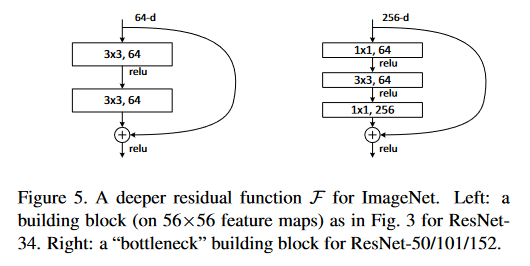

## ResNet architecture:

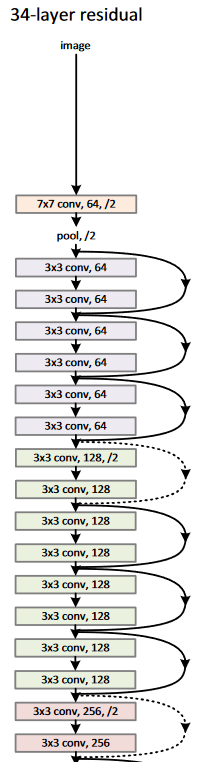
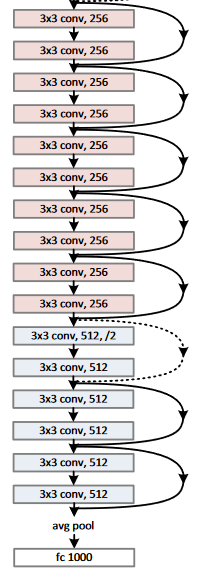

## WideResNet architecture:

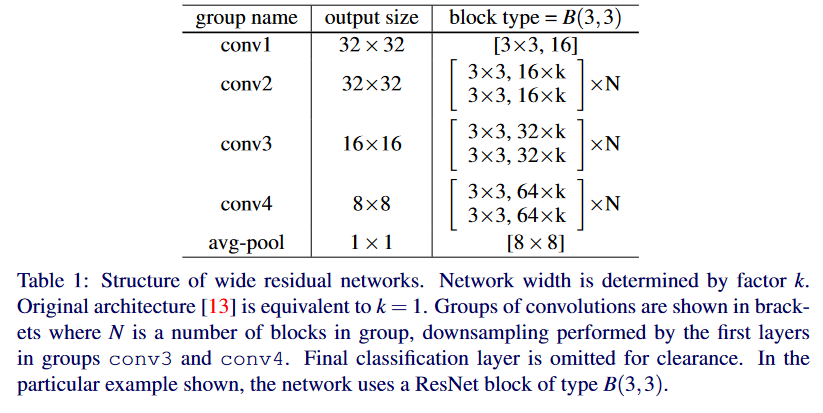
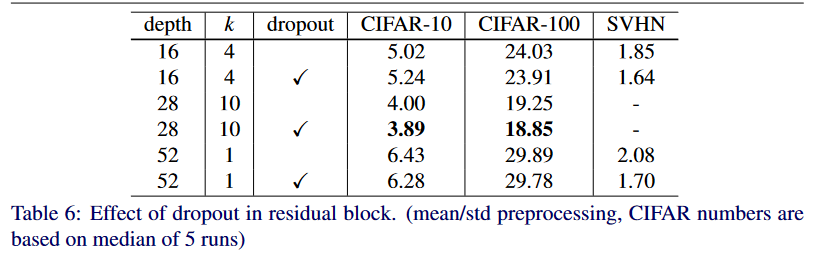
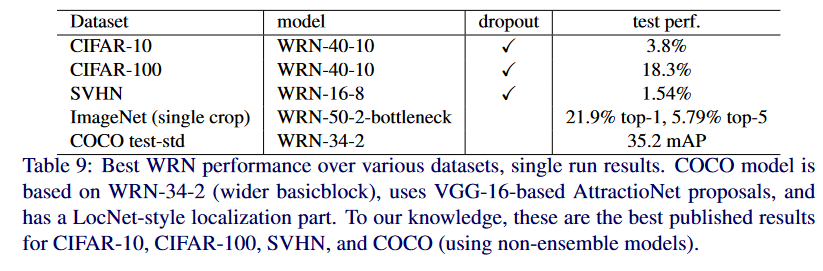

In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, dropout=0):
        # Invoke nn.Module constructor
        super(BasicBlock, self).__init__()
        # First convolution
        self.bn1 = nn.BatchNorm2d(in_channels, dtype=torch.float32)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1,
                               bias=False, dtype=torch.float32)
        
        # Second convolution
        self.bn2 = nn.BatchNorm2d(out_channels, dtype=torch.float32)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1,
                               bias=False, dtype=torch.float32)
        
        self.dropout = dropout
        self.is_first_block = (in_channels != out_channels) # Whether it's a first block in a group
        self.dim_handler = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False,
                      dtype=torch.float32), # 1x1 convolution
            nn.BatchNorm2d(out_channels, dtype=torch.float32)) # batch normalization
        
    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        if self.dropout > 0:
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        
        # If it's a first block in a group we need to handle difference in dimensions
        # between residual connection and output
        return torch.add(self.dim_handler(x) if self.is_first_block else x, out)

class WRNGroup(nn.Module):
    def __init__(self, blocks_num, in_channels, out_channels, stride, dropout=0):
        # Invoke nn.Module constructor
        super(WRNGroup, self).__init__()
        blocks = []
        # Create n blocks, first block has stride possibly != 1
        for i in range(int(blocks_num)):
            blocks.append(BasicBlock(in_channels if i==0 else out_channels, out_channels, stride if i==0 else 1, dropout))
        self.group = nn.Sequential(*blocks)

    def forward(self, x):
        return self.group(x)

class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor=1, dropout=0, num_classes=10):
        # depth = 6*N + 4
        # widen_factor = k
        # Invoke nn.Module constructor
        super(WideResNet, self).__init__()
        channels_num = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        
        assert((depth - 4) % 6 == 0) # Check the corectness of depth
        n = (depth - 4) / 6
        
        # conv1 group
        self.conv1_group = nn.Conv2d(in_channels=3, out_channels=channels_num[0], kernel_size=3,
                                     stride=1, padding=1, bias=False, dtype=torch.float32)
        # conv2 group
        self.conv2_group = WRNGroup(blocks_num=n, in_channels=channels_num[0],
                                    out_channels=channels_num[1], stride=1, dropout=dropout)
        # conv3 group
        self.conv3_group = WRNGroup(blocks_num=n, in_channels=channels_num[1],
                                    out_channels=channels_num[2], stride=2, dropout=dropout)
        # conv4 group
        self.conv4_group = WRNGroup(blocks_num=n, in_channels=channels_num[2],
                                    out_channels=channels_num[3], stride=2, dropout=dropout)
        
        self.out_channels = channels_num[3]
        
        self.bn = nn.BatchNorm2d(self.out_channels, dtype=torch.float32)
        self.relu = nn.ReLU(inplace=True)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.out_channels, num_classes, dtype=torch.float32),
            nn.Softmax(dim=1))

        # Weights and bias initialization
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                # Kaiming ("He") initialization
                # In 'fan_out' mode, it considers the number of output units (fan-out)
                # when calculating the variance
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu') 
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1.0)  # no scale
                module.bias.data.fill_(0.0)  # no shift
            elif isinstance(module, nn.Linear):
                module.bias.data.fill_(0.0) # no initial bias
                
    def forward(self, x):
        out = self.conv1_group(x)
        out = self.conv2_group(out)
        out = self.conv3_group(out)
        out = self.conv4_group(out)
        out = self.relu(self.bn(out)) # Add additional BN + ReLU due to the changed order
        out = F.avg_pool2d(out, 8) # We use average pooling [8 x 8]
        out = out.view(-1, self.out_channels)
        out = self.classifier(out)
        
        return out

# Ordinary training with WideResNet and CIFAR-10

In [21]:
# Set up stohastic gradient descent method, WideResNet with:
# dropout = 0.3
# n=28, k=10
# Adam:
# learning_rate = 0.0015
# weight_decay = 0.0001

wideresnet_nn = WideResNet(depth=28, widen_factor=10, dropout=0.3).to(device)
# optimizer = optim.SGD(wideresnet_nn.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
optimizer = optim.Adam(wideresnet_nn.parameters(), lr=0.0015, weight_decay=1e-4)
wideresnet_ord_model = OrdinaryTraining(wideresnet_nn, optimizer, criterion, accuracy, 
                                       train_loader, test_loader, device,
                                      "/kaggle/working/WideResNet_Ordinary_checkpoints/epoch_6_last_cpt")

Loading OrdinaryTraining model from checkpoint...

!This checkpoint trained for 6 epochs, current start_epoch=7!

Model successfully created!


In [84]:
# train for 30 epochs
wideresnet_ord_model.train_validate_cycle(epochs=5)

Training model for 5 epochs from 26 to 30.


  0%|          | 0/5 [00:00<?, ?it/s]

Current epoch: 26

-------


  0%|          | 0/781 [00:00<?, ?it/s]

Looked at 19136 samples

Current train loss for batch: 1.7919566631317139

Looked at 38336 samples

Current train loss for batch: 1.7046871185302734



Average train loss: 1.73956

Average validation loss: 1.72039, Average validation acc: 74.04%





Saving 26 status:'best' checkpoint, current average accuracy: 74.04% is better than previous best result: 73.34%

Successfully saved epoch 26 status:best checkpoint!



Current epoch: 27

-------


  0%|          | 0/781 [00:00<?, ?it/s]

Looked at 19136 samples

Current train loss for batch: 1.6870806217193604

Looked at 38336 samples

Current train loss for batch: 1.6595350503921509



Average train loss: 1.73724

Average validation loss: 1.75552, Average validation acc: 70.30%





Saving 27 status:'last' checkpoint, current average accuracy: 0.70%

Successfully saved epoch 27 status:last checkpoint!



Current epoch: 28

-------


  0%|          | 0/781 [00:00<?, ?it/s]

Looked at 19136 samples

Current train loss for batch: 1.789699673652649

Looked at 38336 samples

Current train loss for batch: 1.7053333520889282



Average train loss: 1.73225

Average validation loss: 1.74423, Average validation acc: 71.74%





Saving 28 status:'last' checkpoint, current average accuracy: 0.72%

Successfully saved epoch 28 status:last checkpoint!



Current epoch: 29

-------


  0%|          | 0/781 [00:00<?, ?it/s]

Looked at 19136 samples

Current train loss for batch: 1.6460201740264893

Looked at 38336 samples

Current train loss for batch: 1.7537460327148438



Average train loss: 1.73075

Average validation loss: 1.75688, Average validation acc: 70.26%





Saving 29 status:'last' checkpoint, current average accuracy: 0.70%

Successfully saved epoch 29 status:last checkpoint!



Current epoch: 30

-------


  0%|          | 0/781 [00:00<?, ?it/s]

Looked at 19136 samples

Current train loss for batch: 1.7142446041107178

Looked at 38336 samples

Current train loss for batch: 1.8133879899978638



Average train loss: 1.72830

Average validation loss: 1.73719, Average validation acc: 72.33%





Saving 30 status:'last' checkpoint, current average accuracy: 0.72%

Successfully saved epoch 30 status:last checkpoint!




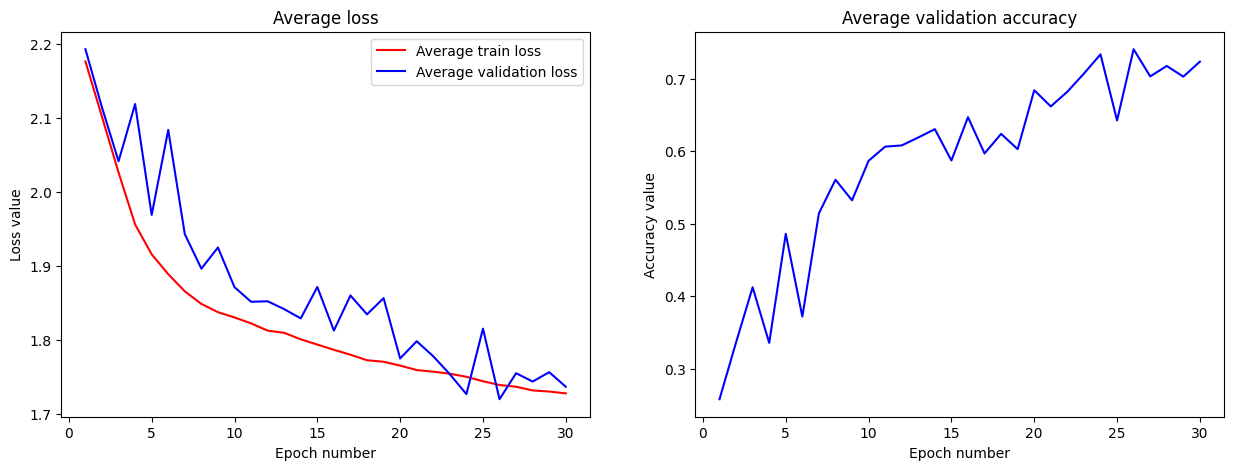

In [85]:
wideresnet_ord_model.plot_loss_acc()

In [87]:
wideresnet_ord_model = OrdinaryTraining(wideresnet_nn, optimizer, criterion, accuracy, 
                                       train_loader, test_loader, device,
                                      "/kaggle/working/WideResNet_Ordinary_checkpoints/epoch_26_best_cpt")
test_loss_score, test_accuracy_score = wideresnet_ord_model.model_test()
print(f"Test loss: {test_loss_score}")
print(f"Test accuracy: {100*test_accuracy_score}%")

Loading OrdinaryTraining model from checkpoint...

!This checkpoint trained for 26 epochs, current start_epoch=27!

Model successfully created!

Test loss: 1.7203890085220337

Test accuracy: 74.04458618164062%


# MixMatch-Training with WideResNet and CIFAR-10

In [29]:
wideresnet_mm_model = MixMatchTraining(lambda: WideResNet(depth=28, widen_factor=10, dropout=0.3),
                                       accuracy, train_labeled_ind, train_unlabeled_ind,
                                       trainset=torchvision.datasets.CIFAR10(root='./data',
                                                                               train=True,
                                                                               download=False),
                                       validset=torchvision.datasets.CIFAR10(root='./data',
                                                                               train=False,
                                                                               download=False),
                                       device=device,
                                       decay_func="exp")

Creating model from scratch...
Model successfully created!


In [30]:
# train for 45 epochs
wideresnet_mm_model.train_validate_cycle(epochs=45)

Training model for 45 epochs from 1 to 45.


  0%|          | 0/45 [00:00<?, ?it/s]

Current epoch: 1/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.1365842819213867
Looked at 12800 samples
Current train loss for batch: 2.163633346557617

Average train loss: 2.11560
Average train loss L_X: 2.11123
Average train loss L_U: 0.00507
Average validation loss: 2.16924
Average validation ema model loss: 2.16851
Average validation accuracy: 31.53%
Average validation ema model accuracy: 31.90%


Saving 1/45 status:'best' checkpoint, current ema model accuracy: 31.90% is better than previous best result: 0.00%
Successfully saved epoch 1 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 2/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.067082166671753
Looked at 12800 samples
Current train loss for batch: 2.020005464553833

Average train loss: 1.94693
Average train loss L_X: 1.93121
Average train loss L_U: 0.00624
Average validation loss: 2.19561
Average validation ema model loss: 2.19132
Average validation accuracy: 27.27%
Average validation ema model accuracy: 27.66%


Saving 2/45 status:'last' checkpoint, current ema model accuracy: 27.66% is worse than previous best result: 31.90%
Successfully saved epoch 2 status:last and ordinary_status:ordinary_last checkpoint!

Current epoch: 3/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.4552669525146484
Looked at 12800 samples
Current train loss for batch: 2.0377116203308105

Average train loss: 1.87286
Average train loss L_X: 1.84181
Average train loss L_U: 0.00740
Average validation loss: 2.12960
Average validation ema model loss: 2.13506
Average validation accuracy: 40.65%
Average validation ema model accuracy: 40.99%


Saving 3/45 status:'best' checkpoint, current ema model accuracy: 40.99% is better than previous best result: 31.90%
Successfully saved epoch 3 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 4/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.457878589630127
Looked at 12800 samples
Current train loss for batch: 2.1131410598754883

Average train loss: 1.78579
Average train loss L_X: 1.73866
Average train loss L_U: 0.00808
Average validation loss: 2.15226
Average validation ema model loss: 2.14258
Average validation accuracy: 33.95%
Average validation ema model accuracy: 34.24%


Saving 4/45 status:'last' checkpoint, current ema model accuracy: 34.24% is worse than previous best result: 40.99%
Successfully saved epoch 4 status:last and ordinary_status:ordinary_last checkpoint!

Current epoch: 5/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.6146777868270874
Looked at 12800 samples
Current train loss for batch: 1.589450716972351

Average train loss: 1.74763
Average train loss L_X: 1.67984
Average train loss L_U: 0.00904
Average validation loss: 2.09484
Average validation ema model loss: 2.09828
Average validation accuracy: 40.84%
Average validation ema model accuracy: 41.28%


Saving 5/45 status:'best' checkpoint, current ema model accuracy: 41.28% is better than previous best result: 40.99%
Successfully saved epoch 5 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 6/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.5381627082824707
Looked at 12800 samples
Current train loss for batch: 1.8806366920471191

Average train loss: 1.67208
Average train loss L_X: 1.58731
Average train loss L_U: 0.00925
Average validation loss: 2.05231
Average validation ema model loss: 2.04058
Average validation accuracy: 47.10%
Average validation ema model accuracy: 49.97%


Saving 6/45 status:'best' checkpoint, current ema model accuracy: 49.97% is better than previous best result: 41.28%
Successfully saved epoch 6 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 7/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.9135048389434814
Looked at 12800 samples
Current train loss for batch: 1.6527718305587769

Average train loss: 1.67858
Average train loss L_X: 1.57212
Average train loss L_U: 0.00981
Average validation loss: 2.09518
Average validation ema model loss: 2.06475
Average validation accuracy: 42.09%
Average validation ema model accuracy: 48.01%


Saving 7/45 status:'last' checkpoint, current ema model accuracy: 48.01% is worse than previous best result: 49.97%
Successfully saved epoch 7 status:last and ordinary_status:ordinary_last checkpoint!

Current epoch: 8/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.1664612293243408
Looked at 12800 samples
Current train loss for batch: 1.8131725788116455

Average train loss: 1.65270
Average train loss L_X: 1.52770
Average train loss L_U: 0.01001
Average validation loss: 2.04067
Average validation ema model loss: 2.01173
Average validation accuracy: 52.10%
Average validation ema model accuracy: 57.69%


Saving 8/45 status:'best' checkpoint, current ema model accuracy: 57.69% is better than previous best result: 49.97%
Successfully saved epoch 8 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 9/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.2767313718795776
Looked at 12800 samples
Current train loss for batch: 1.9500527381896973

Average train loss: 1.60858
Average train loss L_X: 1.46833
Average train loss L_U: 0.00989
Average validation loss: 1.99912
Average validation ema model loss: 1.97717
Average validation accuracy: 56.28%
Average validation ema model accuracy: 58.93%


Saving 9/45 status:'best' checkpoint, current ema model accuracy: 58.93% is better than previous best result: 57.69%
Successfully saved epoch 9 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 10/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.224410057067871
Looked at 12800 samples
Current train loss for batch: 1.67417311668396

Average train loss: 1.62207
Average train loss L_X: 1.45889
Average train loss L_U: 0.01031
Average validation loss: 2.05358
Average validation ema model loss: 1.97656
Average validation accuracy: 49.93%
Average validation ema model accuracy: 60.33%


Saving 10/45 status:'best' checkpoint, current ema model accuracy: 60.33% is better than previous best result: 58.93%
Successfully saved epoch 10 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 11/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.2053651809692383
Looked at 12800 samples
Current train loss for batch: 1.3964812755584717

Average train loss: 1.64450
Average train loss L_X: 1.45246
Average train loss L_U: 0.01098
Average validation loss: 1.98891
Average validation ema model loss: 1.94410
Average validation accuracy: 58.28%
Average validation ema model accuracy: 65.00%


Saving 11/45 status:'best' checkpoint, current ema model accuracy: 65.00% is better than previous best result: 60.33%
Successfully saved epoch 11 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 12/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.1635284423828125
Looked at 12800 samples
Current train loss for batch: 1.854223608970642

Average train loss: 1.61986
Average train loss L_X: 1.41522
Average train loss L_U: 0.01068
Average validation loss: 1.94088
Average validation ema model loss: 1.92264
Average validation accuracy: 62.83%
Average validation ema model accuracy: 66.22%


Saving 12/45 status:'best' checkpoint, current ema model accuracy: 66.22% is better than previous best result: 65.00%
Successfully saved epoch 12 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 13/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.061818838119507
Looked at 12800 samples
Current train loss for batch: 2.133456230163574

Average train loss: 1.62756
Average train loss L_X: 1.40198
Average train loss L_U: 0.01083
Average validation loss: 1.96906
Average validation ema model loss: 1.87442
Average validation accuracy: 56.68%
Average validation ema model accuracy: 70.44%


Saving 13/45 status:'best' checkpoint, current ema model accuracy: 70.44% is better than previous best result: 66.22%
Successfully saved epoch 13 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 14/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.438328504562378
Looked at 12800 samples
Current train loss for batch: 1.0620179176330566

Average train loss: 1.56606
Average train loss L_X: 1.33510
Average train loss L_U: 0.01027
Average validation loss: 1.89680
Average validation ema model loss: 1.84049
Average validation accuracy: 64.56%
Average validation ema model accuracy: 73.12%


Saving 14/45 status:'best' checkpoint, current ema model accuracy: 73.12% is better than previous best result: 70.44%
Successfully saved epoch 14 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 15/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.664943814277649
Looked at 12800 samples
Current train loss for batch: 1.3395397663116455

Average train loss: 1.56237
Average train loss L_X: 1.31016
Average train loss L_U: 0.01044
Average validation loss: 1.85990
Average validation ema model loss: 1.81496
Average validation accuracy: 69.76%
Average validation ema model accuracy: 75.79%


Saving 15/45 status:'best' checkpoint, current ema model accuracy: 75.79% is better than previous best result: 73.12%
Successfully saved epoch 15 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 16/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.1124587059020996
Looked at 12800 samples
Current train loss for batch: 2.1884372234344482

Average train loss: 1.57129
Average train loss L_X: 1.29579
Average train loss L_U: 0.01067
Average validation loss: 1.85402
Average validation ema model loss: 1.80961
Average validation accuracy: 71.45%
Average validation ema model accuracy: 76.65%


Saving 16/45 status:'best' checkpoint, current ema model accuracy: 76.65% is better than previous best result: 75.79%
Successfully saved epoch 16 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 17/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.678098440170288
Looked at 12800 samples
Current train loss for batch: 2.446349620819092

Average train loss: 1.58076
Average train loss L_X: 1.28555
Average train loss L_U: 0.01073
Average validation loss: 1.81320
Average validation ema model loss: 1.78165
Average validation accuracy: 75.31%
Average validation ema model accuracy: 79.02%


Saving 17/45 status:'best' checkpoint, current ema model accuracy: 79.02% is better than previous best result: 76.65%
Successfully saved epoch 17 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 18/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.0311627388000488
Looked at 12800 samples
Current train loss for batch: 2.265169620513916

Average train loss: 1.55249
Average train loss L_X: 1.24683
Average train loss L_U: 0.01048
Average validation loss: 1.86606
Average validation ema model loss: 1.76207
Average validation accuracy: 72.57%
Average validation ema model accuracy: 80.05%


Saving 18/45 status:'best' checkpoint, current ema model accuracy: 80.05% is better than previous best result: 79.02%
Successfully saved epoch 18 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 19/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.3491430282592773
Looked at 12800 samples
Current train loss for batch: 1.3130441904067993

Average train loss: 1.52563
Average train loss L_X: 1.21259
Average train loss L_U: 0.01016
Average validation loss: 1.76457
Average validation ema model loss: 1.75577
Average validation accuracy: 78.58%
Average validation ema model accuracy: 80.06%


Saving 19/45 status:'best' checkpoint, current ema model accuracy: 80.06% is better than previous best result: 80.05%
Successfully saved epoch 19 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 20/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.331668496131897
Looked at 12800 samples
Current train loss for batch: 1.60316801071167

Average train loss: 1.58124
Average train loss L_X: 1.23913
Average train loss L_U: 0.01053
Average validation loss: 1.81453
Average validation ema model loss: 1.74516
Average validation accuracy: 75.19%
Average validation ema model accuracy: 81.35%


Saving 20/45 status:'best' checkpoint, current ema model accuracy: 81.35% is better than previous best result: 80.06%
Successfully saved epoch 20 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 21/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.184938907623291
Looked at 12800 samples
Current train loss for batch: 0.8646711111068726

Average train loss: 1.61905
Average train loss L_X: 1.24025
Average train loss L_U: 0.01108
Average validation loss: 1.83922
Average validation ema model loss: 1.74107
Average validation accuracy: 76.01%
Average validation ema model accuracy: 82.08%


Saving 21/45 status:'best' checkpoint, current ema model accuracy: 82.08% is better than previous best result: 81.35%
Successfully saved epoch 21 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 22/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.357510805130005
Looked at 12800 samples
Current train loss for batch: 1.1867101192474365

Average train loss: 1.56817
Average train loss L_X: 1.19020
Average train loss L_U: 0.01055
Average validation loss: 1.72367
Average validation ema model loss: 1.73286
Average validation accuracy: 81.33%
Average validation ema model accuracy: 82.76%


Saving 22/45 status:'best' checkpoint, current ema model accuracy: 82.76% is better than previous best result: 82.08%
Successfully saved epoch 22 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 23/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.476415753364563
Looked at 12800 samples
Current train loss for batch: 1.7360213994979858

Average train loss: 1.61681
Average train loss L_X: 1.21704
Average train loss L_U: 0.01066
Average validation loss: 1.77015
Average validation ema model loss: 1.72694
Average validation accuracy: 79.90%
Average validation ema model accuracy: 83.38%


Saving 23/45 status:'best' checkpoint, current ema model accuracy: 83.38% is better than previous best result: 82.76%
Successfully saved epoch 23 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 24/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.400611162185669
Looked at 12800 samples
Current train loss for batch: 2.4464879035949707

Average train loss: 1.65894
Average train loss L_X: 1.22301
Average train loss L_U: 0.01113
Average validation loss: 1.72229
Average validation ema model loss: 1.72478
Average validation accuracy: 81.59%
Average validation ema model accuracy: 83.63%


Saving 24/45 status:'best' checkpoint, current ema model accuracy: 83.63% is better than previous best result: 83.38%
Successfully saved epoch 24 status:best and ordinary_status:ordinary_best checkpoint!

Current epoch: 25/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.9934418201446533
Looked at 12800 samples
Current train loss for batch: 1.0592433214187622

Average train loss: 1.66387
Average train loss L_X: 1.20369
Average train loss L_U: 0.01127
Average validation loss: 1.73599
Average validation ema model loss: 1.72136
Average validation accuracy: 81.46%
Average validation ema model accuracy: 83.96%


Saving 25/45 status:'best' checkpoint, current ema model accuracy: 83.96% is better than previous best result: 83.63%
Successfully saved epoch 25 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 26/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.4242472648620605
Looked at 12800 samples
Current train loss for batch: 2.1029367446899414

Average train loss: 1.61933
Average train loss L_X: 1.17638
Average train loss L_U: 0.01041
Average validation loss: 1.75421
Average validation ema model loss: 1.71922
Average validation accuracy: 81.22%
Average validation ema model accuracy: 84.00%


Saving 26/45 status:'best' checkpoint, current ema model accuracy: 84.00% is better than previous best result: 83.96%
Successfully saved epoch 26 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 27/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.7281255722045898
Looked at 12800 samples
Current train loss for batch: 2.5285160541534424

Average train loss: 1.69809
Average train loss L_X: 1.20476
Average train loss L_U: 0.01116
Average validation loss: 1.75409
Average validation ema model loss: 1.72072
Average validation accuracy: 84.65%
Average validation ema model accuracy: 83.83%


Saving 27/45 status:'last' checkpoint, current ema model accuracy: 83.83% is worse than previous best result: 84.00%
Successfully saved epoch 27 status:last and ordinary_status:ordinary_best checkpoint!

Current epoch: 28/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.9796440601348877
Looked at 12800 samples
Current train loss for batch: 0.7957115769386292

Average train loss: 1.67163
Average train loss L_X: 1.17011
Average train loss L_U: 0.01094
Average validation loss: 1.75072
Average validation ema model loss: 1.71753
Average validation accuracy: 80.23%
Average validation ema model accuracy: 84.40%


Saving 28/45 status:'best' checkpoint, current ema model accuracy: 84.40% is better than previous best result: 84.00%
Successfully saved epoch 28 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 29/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.1167478561401367
Looked at 12800 samples
Current train loss for batch: 1.2257156372070312

Average train loss: 1.68007
Average train loss L_X: 1.17132
Average train loss L_U: 0.01072
Average validation loss: 1.73253
Average validation ema model loss: 1.71288
Average validation accuracy: 81.57%
Average validation ema model accuracy: 84.71%


Saving 29/45 status:'best' checkpoint, current ema model accuracy: 84.71% is better than previous best result: 84.40%
Successfully saved epoch 29 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 30/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.842482089996338
Looked at 12800 samples
Current train loss for batch: 0.6477667093276978

Average train loss: 1.79128
Average train loss L_X: 1.21780
Average train loss L_U: 0.01167
Average validation loss: 1.79766
Average validation ema model loss: 1.71176
Average validation accuracy: 74.99%
Average validation ema model accuracy: 84.95%


Saving 30/45 status:'best' checkpoint, current ema model accuracy: 84.95% is better than previous best result: 84.71%
Successfully saved epoch 30 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 31/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.113945722579956
Looked at 12800 samples
Current train loss for batch: 2.818985939025879

Average train loss: 1.76561
Average train loss L_X: 1.19708
Average train loss L_U: 0.01119
Average validation loss: 1.76062
Average validation ema model loss: 1.71287
Average validation accuracy: 80.49%
Average validation ema model accuracy: 84.96%


Saving 31/45 status:'best' checkpoint, current ema model accuracy: 84.96% is better than previous best result: 84.95%
Successfully saved epoch 31 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 32/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.654670238494873
Looked at 12800 samples
Current train loss for batch: 1.4701335430145264

Average train loss: 1.68308
Average train loss L_X: 1.15076
Average train loss L_U: 0.01014
Average validation loss: 1.76959
Average validation ema model loss: 1.71109
Average validation accuracy: 81.33%
Average validation ema model accuracy: 84.91%


Saving 32/45 status:'last' checkpoint, current ema model accuracy: 84.91% is worse than previous best result: 84.96%
Successfully saved epoch 32 status:last and ordinary_status:ordinary_last checkpoint!

Current epoch: 33/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.4763681888580322
Looked at 12800 samples
Current train loss for batch: 1.110737919807434

Average train loss: 1.70908
Average train loss L_X: 1.14749
Average train loss L_U: 0.01037
Average validation loss: 1.72637
Average validation ema model loss: 1.70852
Average validation accuracy: 82.48%
Average validation ema model accuracy: 85.29%


Saving 33/45 status:'best' checkpoint, current ema model accuracy: 85.29% is better than previous best result: 84.96%
Successfully saved epoch 33 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 34/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.244009017944336
Looked at 12800 samples
Current train loss for batch: 1.2052067518234253

Average train loss: 1.71109
Average train loss L_X: 1.13077
Average train loss L_U: 0.01039
Average validation loss: 1.73967
Average validation ema model loss: 1.70513
Average validation accuracy: 82.62%
Average validation ema model accuracy: 85.48%


Saving 34/45 status:'best' checkpoint, current ema model accuracy: 85.48% is better than previous best result: 85.29%
Successfully saved epoch 34 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 35/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.7303106784820557
Looked at 12800 samples
Current train loss for batch: 1.1038167476654053

Average train loss: 1.75997
Average train loss L_X: 1.14477
Average train loss L_U: 0.01070
Average validation loss: 1.73274
Average validation ema model loss: 1.70230
Average validation accuracy: 78.43%
Average validation ema model accuracy: 85.53%


Saving 35/45 status:'best' checkpoint, current ema model accuracy: 85.53% is better than previous best result: 85.48%
Successfully saved epoch 35 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 36/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.7984585762023926
Looked at 12800 samples
Current train loss for batch: 2.1681067943573

Average train loss: 1.77112
Average train loss L_X: 1.15503
Average train loss L_U: 0.01041
Average validation loss: 1.76659
Average validation ema model loss: 1.70196
Average validation accuracy: 81.97%
Average validation ema model accuracy: 85.59%


Saving 36/45 status:'best' checkpoint, current ema model accuracy: 85.59% is better than previous best result: 85.53%
Successfully saved epoch 36 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 37/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.4262776374816895
Looked at 12800 samples
Current train loss for batch: 1.361178994178772

Average train loss: 1.80542
Average train loss L_X: 1.15555
Average train loss L_U: 0.01068
Average validation loss: 1.68335
Average validation ema model loss: 1.69988
Average validation accuracy: 84.22%
Average validation ema model accuracy: 85.93%


Saving 37/45 status:'best' checkpoint, current ema model accuracy: 85.93% is better than previous best result: 85.59%
Successfully saved epoch 37 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 38/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.9312734603881836
Looked at 12800 samples
Current train loss for batch: 1.456400990486145

Average train loss: 1.86944
Average train loss L_X: 1.18251
Average train loss L_U: 0.01099
Average validation loss: 1.70891
Average validation ema model loss: 1.69936
Average validation accuracy: 83.39%
Average validation ema model accuracy: 86.05%


Saving 38/45 status:'best' checkpoint, current ema model accuracy: 86.05% is better than previous best result: 85.93%
Successfully saved epoch 38 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 39/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 3.150981903076172
Looked at 12800 samples
Current train loss for batch: 2.3079352378845215

Average train loss: 1.81713
Average train loss L_X: 1.14497
Average train loss L_U: 0.01047
Average validation loss: 1.73935
Average validation ema model loss: 1.69772
Average validation accuracy: 82.84%
Average validation ema model accuracy: 86.01%


Saving 39/45 status:'last' checkpoint, current ema model accuracy: 86.01% is worse than previous best result: 86.05%
Successfully saved epoch 39 status:last and ordinary_status:ordinary_last checkpoint!

Current epoch: 40/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 0.9351611137390137
Looked at 12800 samples
Current train loss for batch: 1.1028844118118286

Average train loss: 1.93375
Average train loss L_X: 1.19808
Average train loss L_U: 0.01117
Average validation loss: 1.76728
Average validation ema model loss: 1.69436
Average validation accuracy: 80.24%
Average validation ema model accuracy: 86.25%


Saving 40/45 status:'best' checkpoint, current ema model accuracy: 86.25% is better than previous best result: 86.05%
Successfully saved epoch 40 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 41/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.8300862312316895
Looked at 12800 samples
Current train loss for batch: 2.9215164184570312

Average train loss: 1.92461
Average train loss L_X: 1.17613
Average train loss L_U: 0.01109
Average validation loss: 1.75525
Average validation ema model loss: 1.69307
Average validation accuracy: 81.92%
Average validation ema model accuracy: 86.38%


Saving 41/45 status:'best' checkpoint, current ema model accuracy: 86.38% is better than previous best result: 86.25%
Successfully saved epoch 41 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 42/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.855647325515747
Looked at 12800 samples
Current train loss for batch: 2.493171215057373

Average train loss: 1.97170
Average train loss L_X: 1.18386
Average train loss L_U: 0.01139
Average validation loss: 1.74111
Average validation ema model loss: 1.68932
Average validation accuracy: 83.15%
Average validation ema model accuracy: 86.66%


Saving 42/45 status:'best' checkpoint, current ema model accuracy: 86.66% is better than previous best result: 86.38%
Successfully saved epoch 42 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 43/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 0.7126015424728394
Looked at 12800 samples
Current train loss for batch: 3.196364402770996

Average train loss: 1.94802
Average train loss L_X: 1.17320
Average train loss L_U: 0.01094
Average validation loss: 1.71731
Average validation ema model loss: 1.68726
Average validation accuracy: 84.63%
Average validation ema model accuracy: 86.91%


Saving 43/45 status:'best' checkpoint, current ema model accuracy: 86.91% is better than previous best result: 86.66%
Successfully saved epoch 43 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 44/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 2.970221996307373
Looked at 12800 samples
Current train loss for batch: 1.8758606910705566

Average train loss: 1.97863
Average train loss L_X: 1.19294
Average train loss L_U: 0.01084
Average validation loss: 1.75984
Average validation ema model loss: 1.68652
Average validation accuracy: 82.68%
Average validation ema model accuracy: 87.15%


Saving 44/45 status:'best' checkpoint, current ema model accuracy: 87.15% is better than previous best result: 86.91%
Successfully saved epoch 44 status:best and ordinary_status:ordinary_last checkpoint!

Current epoch: 45/45
-------


  0%|          | 0/234 [00:00<?, ?it/s]

Looked at 6400 samples
Current train loss for batch: 1.5680028200149536
Looked at 12800 samples
Current train loss for batch: 2.623903751373291

Average train loss: 1.93266
Average train loss L_X: 1.15208
Average train loss L_U: 0.01053
Average validation loss: 1.71426
Average validation ema model loss: 1.68425
Average validation accuracy: 81.76%
Average validation ema model accuracy: 87.24%


Saving 45/45 status:'best' checkpoint, current ema model accuracy: 87.24% is better than previous best result: 87.15%
Successfully saved epoch 45 status:best and ordinary_status:ordinary_last checkpoint!



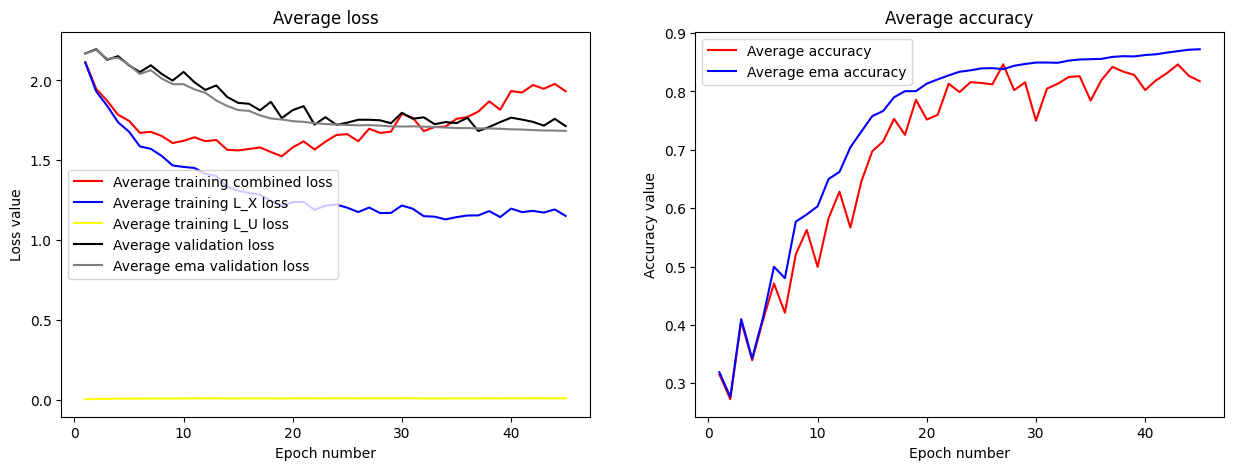

In [31]:
wideresnet_mm_model.plot_loss_acc()

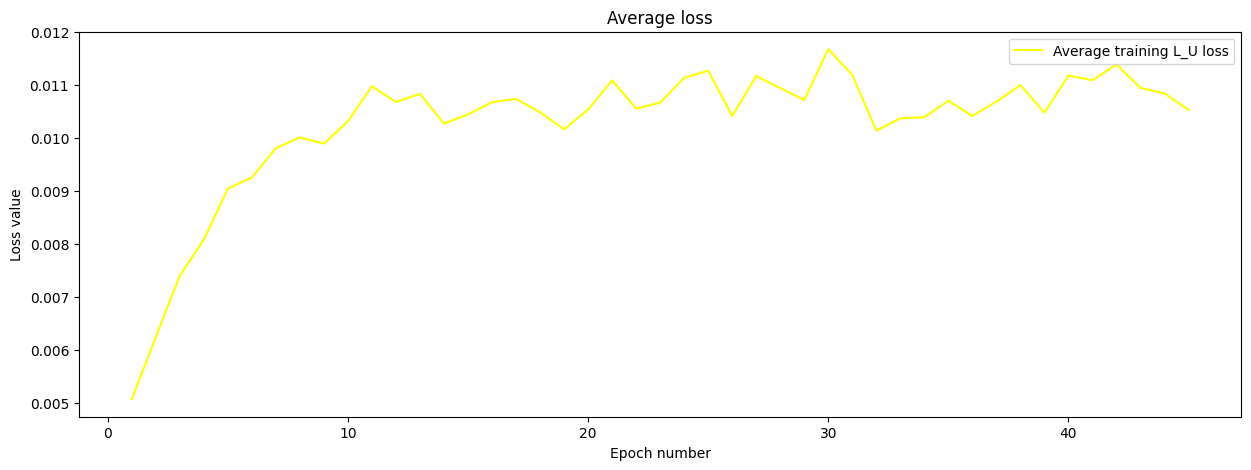

In [33]:
plt.figure(figsize = (15, 5))
epoch_arr = np.arange(1, wideresnet_mm_model.epochs + 1)
plt.plot(epoch_arr, wideresnet_mm_model.train_loss_u_arr, 'yellow', label="Average training L_U loss")
plt.title("Average loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.legend()
plt.show()

In [35]:
test_loss_res, test_acc_score, test_loss_ema_res, test_acc_ema_score = wideresnet_mm_model.model_test()
print(f"Test loss: {test_loss_res}")
print(f"Test accuracy: {100*test_acc_score}%")
print(f"Test ema loss: {test_loss_ema_res}")
print(f"Test ema accuracy: {100*test_acc_ema_score}%")

Test loss: 1.7142590610844315
Test accuracy: 81.75756369426752%
Test ema loss: 1.6842536189753539
Test ema accuracy: 87.24124203821655%


In [ ]:
del wideresnet_mm_model
gc.collect()
torch.cuda.empty_cache()

# Results comparison
|   |     **Learning algorithm**    | Training time | Number of epochs | Best result epoch | Best validation accuracy |
|---|-------------------------------|---------------|------------------|-------------------|--------------------------|
| 1 | Ordinary                      | 3 hours       | 30               | 26                | 74.04%                   |
| 2 | MixMatch-Training (exp decay) | 3 hours       | 45               | 45                | 87.24%  (ema model)       |

### Weights extraction from best checkpoints (and check for MixMatchTraining)

In [6]:
ord_train_model_weights = torch.load(
        "/kaggle/input/ssl-lab4-supplementary-data/OrdinaryTraining_epoch_26_best_cpt"
    )['model_param']
mixmatch_train_model_weights = torch.load(
        "/kaggle/input/ssl-lab4-supplementary-data/MixMatchTraining_epoch_45_best_cpt"
    )['ema_optim_state'].ema_model.state_dict()

torch.save(ord_train_model_weights, "OrdinaryTraining_epoch_26_best_cpt_weights.pth")
torch.save(mixmatch_train_model_weights, "MixMatchTraining_epoch_45_best_cpt_weights.pth")

In [17]:
wideresnet_nn_test = WideResNet(depth=28, widen_factor=10, dropout=0.3).to(device)
wideresnet_nn_test.load_state_dict(torch.load('/kaggle/working/MixMatchTraining_epoch_45_best_cpt_weights.pth'))
wideresnet_nn_test.eval()
test_loss = test_acc = 0

# Turn on inference mode (no autograd)
with torch.inference_mode():
    for test_inputs, test_labels in test_loader:
        # Send data to cuda (preferably)
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        # Find predictions for both models
        logits = wideresnet_nn_test(test_inputs).to(device)

        # Test accuracy calculation
        test_loss += criterion(logits, test_labels).item()
        test_acc += accuracy(logits.argmax(dim=1), test_labels).item()

        # Clearing memory
        del test_inputs
        del test_labels
        del logits
##### Test end #####

    # Calculate average loss and accuracy
    test_loss_res = test_loss / len(test_loader)
    test_acc_score = test_acc / len(test_loader)

    gc.collect()
    torch.cuda.empty_cache()

print(test_loss_res)
print(100 * test_acc_score)

1.6842536189753539
87.24124203821655
